## Demo Class Camera

In [2]:
from basisklassen_cam import Camera
import matplotlib.pylab as plt

In [3]:
Camera?

Init signature:
Camera(
    devicenumber: int = 0,
    buffersize: int = 1,
    skip_frame: int = 0,
    height: int = None,
    width: int = None,
    flip: bool = True,
    colorspace: str = 'bgr',
) -> None
Docstring:      <no docstring>
Init docstring:
Initializes Camera

Args:
    devicenumber (int, optional): Identifies camera to be used.
        0 for default camera. Defaults to 0.
    buffersize (int, optional): _description_. Defaults to 1.
    skip_frame (int, optional): _description_. Defaults to 0.
    height (int, optional): height of images. Defaults to None -> height defaults to camera.
    width (int, optional): height. Defaults to None -> width defaults to camera
    flip (bool, optional): mirrow image on the horizonal axis. Defaults to True.
    colorspace (str, optional): 'bgr', 'rgb', 'gray' Defaults to 'bgr'.

Note:
    Note: Some camera do not support a free choice of height and width.
    When trying to set width or height, they default to supported formats.
    

### Simple usage with default parameters with get_frame and release

Return value of get_frame: <class 'numpy.ndarray'>
Shape of NumPy-Array: (480, 640, 3)


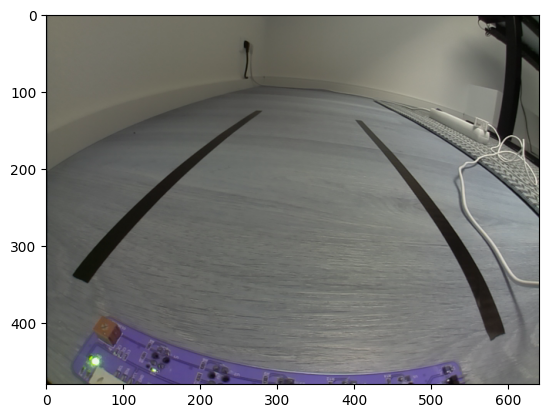

In [4]:
cam = Camera()
img = cam.get_frame()
cam.release()
plt.imshow(img)

print('Return value of get_frame:',type(img))
print('Shape of NumPy-Array:',img.shape)

### Methodes check, release and get_size

In [ ]:
cam = Camera()
img = cam.get_frame()
print('Image size:',cam.get_size(),'depends on camera if not specified.') 
print('Check before release of camera:',cam.check())
cam.release()
print('Check after release of camera:',cam.check())

### Initial parameter (flip)

In [ ]:
cam = Camera(flip = False)

print('Image size:',cam.get_size())
img = cam.get_frame()
print('Shape of NumPy-Array:',img.shape)
cam.release()

plt.imshow(img)

### Initial parameter (colorspace='rgb')

In [ ]:
cam = Camera(
            #flip = False,
            colorspace = 'rgb'
            )

print('Image size:',cam.get_size())
img = cam.get_frame()
print('Shape of NumPy-Array:',img.shape)
cam.release()

plt.imshow(img)

### Initial parameter (colorspace='gray')

In [ ]:
cam = Camera(
            #flip = False,
            colorspace = 'gray'
            )

print('Image size:',cam.get_size())
img = cam.get_frame()
print('Shape of NumPy-Array:',img.shape)
cam.release()

plt.imshow(img,cmap='gray')

### Initial parameter (height,width)

Note: Some camera do not support a free choice of height and width. When trying to set width or height, they default to supported formats. This does not concern the camera used on the RPi! 

In [ ]:
cam = Camera(
            height = 48, # !
            width = 64,  # !
            #flip = False,
            colorspace='rgb',
            ) #default ist bgr

print('Image size:',cam.get_size())
img = cam.get_frame()
print('Shape of NumPy-Array:',img.shape)
cam.release()

plt.imshow(img)

### Inital parameter (skip_frame)

Check whether a change in the setup of an image is reflexed in the next frame from the camera.
If not the video buffer of the camera has to be emptied by usage of skip_frame.

In [ ]:
cam = Camera(devicenumber = 0,
            buffersize = 10,
            skip_frame = 0,
            height = 480,
            width = 640,
            flip = True,
            colorspace = 'rgb')

img = cam.get_frame()
plt.imshow(img)

In [ ]:
img = cam.get_frame()
plt.imshow(img)

In [ ]:
cam.release()

### OpenCV only

True


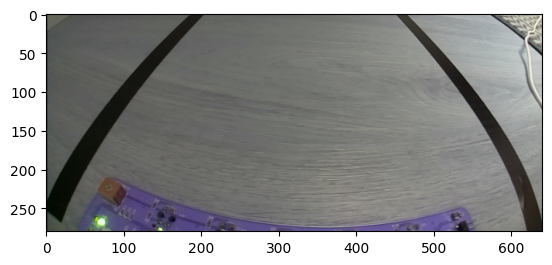

In [65]:
import cv2
vc = cv2.VideoCapture(0)
ret,frame = vc.read()
frame = cv2.flip(frame,-1)
frame = frame[200:480,0:640].copy()
print(ret)
plt.imshow(frame)



Template <class 'numpy.ndarray'> (100, 550, 3)


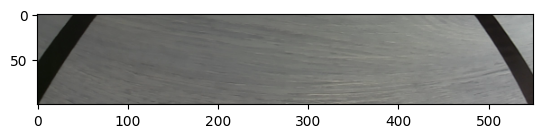

In [84]:
imgTemplate = frame[100:200,50:600].copy()
plt.imshow(imgTemplate,cmap='gray')
print('Template',type(imgTemplate),imgTemplate.shape)


0.0 118426568.0 (100, 125) (240, 16)


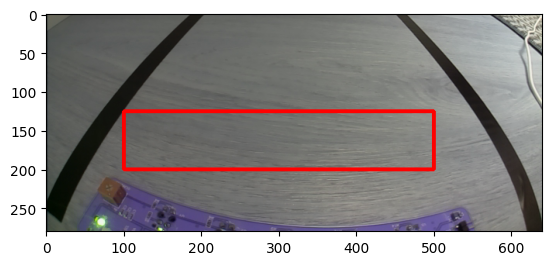

In [71]:
res = cv2.matchTemplate( frame, # Auszuwertendes Bild (NumPy-Array) 
    imgTemplate,
    cv2.TM_SQDIFF  ) 
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
print(min_val, max_val, min_loc, max_loc)

top_left = min_loc #
#-------------------------
# Zeichen der Boundary Box
ht,wt,_ = imgTemplate.shape
bottom_right = (top_left[0] + wt, top_left[1] + ht)
img3=cv2.rectangle(frame.copy(), top_left, bottom_right, (255,0,0), 3)
h,w,_ =frame.shape
#img2[h-ht:h,0:wt]=imgTemplate  # Zusätzlich wird das Template mit in das Bild eingezeichnet
#print(img3,min_val,max_val,res)

plt.imshow(img3)



True


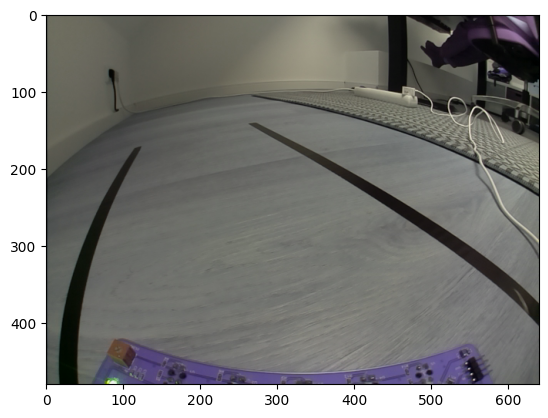

In [90]:
vc = cv2.VideoCapture(0)
ret,frame1 = vc.read()
frame1 = cv2.flip(frame1,-1)
print(ret)
plt.imshow(frame1)


In [91]:
res = cv2.matchTemplate(frame1, imgTemplate, cv2.TM_SQDIFF)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
#-- IHR CODE -------------
top_left = min_loc #
#-------------------------
# Zeichen der Boundary Box
ht,wt,_ = imgTemplate.shape
bottom_right = (top_left[0] + wt, top_left[1] + ht)
img2=cv2.rectangle(frame1.copy(), top_left, bottom_right, (255,0,0), 3)
h,w,_ =frame1.shape
#img2[h-ht:h,0:wt]=imgTemplate  # Zusätzlich wird das Template mit in das Bild eingezeichnet
#print(img2,min_val,max_val,res)


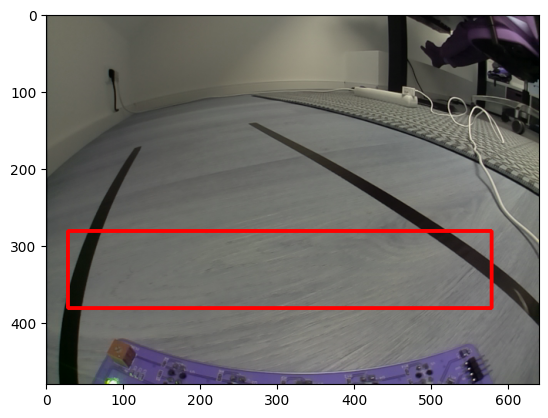

In [92]:

plt.imshow(img2)
   

In [12]:
vc.release()